## FBProphet Time Series & Box-Cox Simple Practice

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
df = pd.read_csv('medium_posts.csv',sep='\t')

In [3]:
df

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...
...,...,...,...
92186,2017-05-23 17:15:09.193Z,medium.com,https://medium.com/@KyleAndrews1994/its-time-t...
92187,2017-01-31 09:59:12.316Z,medium.com,https://medium.com/silent-protagonist/next-wee...
92188,2017-02-16 14:15:20.116Z,medium.com,https://medium.com/@utapartment26/there-used-t...
92189,2017-06-27 10:16:21.668Z,medium.com,https://medium.com/silent-protagonist/the-snes...


In [4]:
df['published'] = pd.to_datetime(df['published'])

In [5]:
df['published'] = df['published'].dt.tz_localize(None)

In [6]:
df

,published,domain,url
0,2012-08-13 22:54:53.510,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...
...,...,...,...
92186,2017-05-23 17:15:09.193,medium.com,https://medium.com/@KyleAndrews1994/its-time-t...
92187,2017-01-31 09:59:12.316,medium.com,https://medium.com/silent-protagonist/next-wee...
92188,2017-02-16 14:15:20.116,medium.com,https://medium.com/@utapartment26/there-used-t...
92189,2017-06-27 10:16:21.668,medium.com,https://medium.com/silent-protagonist/the-snes...


In [7]:
df = df[['published', 'url']].dropna().drop_duplicates()

In [8]:
df.sort_values(by=['published']).head(n=3)

,published,url
50931,1970-01-01 00:00:00.001,https://medium.com/iiot
40243,1970-01-01 00:00:00.001,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


In [9]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2017-06-26')].sort_values(by=['published'])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-social...


In [10]:
df.tail(n=3)

,published,url
62122,2017-06-25 23:36:01.171,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43.000,http://www.johanr.com/blog/people-support-dreams


In [11]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']

In [12]:
aggr_df.head(n=3)

,posts
published,
2012-08-15 00:25:03.373,1
2012-08-15 00:25:29.419,1
2012-08-15 00:34:59.502,1


In [13]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4


In [14]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [15]:
plotly_df(daily_df, title='Posts on Medium (daily)')

In [16]:
weekly_df = daily_df.resample('W').apply(sum)

In [17]:
plotly_df(weekly_df, title='Posts on Medium (weekly)')

In [18]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head(n=3)

,posts
published,
2015-01-01,8
2015-01-02,11
2015-01-03,11


In [19]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


In [20]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


In [21]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


In [23]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,276.306070,253.181314,302.705815,275.879091,276.772833,2.407683,2.407683,2.407683,3.477942,3.477942,3.477942,-1.070260,-1.070260,-1.070260,0.0,0.0,0.0,278.713753
905,2017-06-24,277.007947,216.906056,267.741330,276.551189,277.510587,-34.899970,-34.899970,-34.899970,-34.026227,-34.026227,-34.026227,-0.873743,-0.873743,-0.873743,0.0,0.0,0.0,242.107977
906,2017-06-25,277.709824,222.453351,270.686963,277.227387,278.249167,-31.260139,-31.260139,-31.260139,-30.582275,-30.582275,-30.582275,-0.677864,-0.677864,-0.677864,0.0,0.0,0.0,246.449685


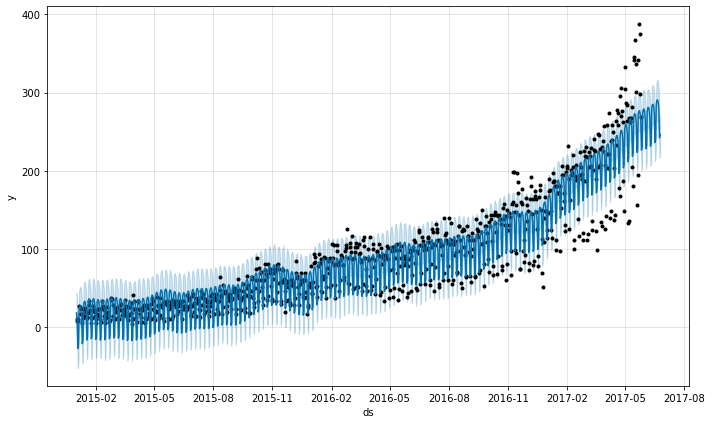

In [24]:
m.plot(forecast);

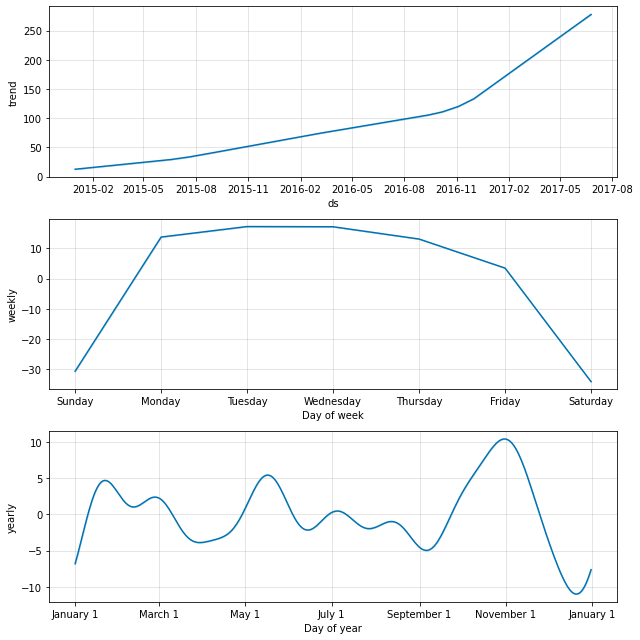

In [25]:
m.plot_components(forecast);

In [26]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [27]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [28]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,278.713753,253.181314,302.705815,421
2017-06-24,242.107977,216.906056,267.741330,277
2017-06-25,246.449685,222.453351,270.686963,253


In [29]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [30]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.70963979704409
MAE 70.37587909647387


In [31]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')

In [32]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [33]:
train_df2 = train_df.copy().set_index('ds')

In [34]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [35]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [37]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.638850654476004
MAE 39.28050400479044


In [38]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')